In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets
!pip install --upgrade sympy
!pip install --upgrade datasets
!pip install evaluate
!pip install transformers
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 48.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Unin

In [ ]:
!unzip "/content/drive/MyDrive/Assignments/심신개/심신개 데이터셋/data_validmask.zip"
!unzip "/content/drive/MyDrive/Assignments/심신개/심신개 데이터셋/DPT-model.zip"
!unzip "/content/drive/MyDrive/Assignments/심신개/심신개 데이터셋/Segformer-model.zip"
!unzip "/content/drive/MyDrive/Assignments/심신개/심신개 데이터셋/2class_Mask2Former.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: content/car_damage_data_v/train/image/0510887_as-0061522.jpg  
  inflating: content/car_damage_data_v/train/image/0511957_sc-227711.jpg  
  inflating: content/car_damage_data_v/train/image/0517932_sc-136022.jpg  
  inflating: content/car_damage_data_v/train/image/0546646_as-3436819.jpg  
  inflating: content/car_damage_data_v/train/image/0561350_sc-215358.jpg  
  inflating: content/car_damage_data_v/train/image/0548943_sc-194535.jpg  
  inflating: content/car_damage_data_v/train/image/0511876_sc-225607.jpg  
  inflating: content/car_damage_data_v/train/image/0528678_sc-213491.jpg  
  inflating: content/car_damage_data_v/train/image/0547016_as-0043807.jpg  
  inflating: content/car_damage_data_v/train/image/0514768_sc-1025070.jpg  
  inflating: content/car_damage_data_v/train/image/0561963_sc-1022924.jpg  
  inflating: content/car_damage_data_v/train/image/0535529_as-0015223.jpg  
  inflating: content/car_damage_data_v/train/image/0525926

In [ ]:
import os
from datasets import Dataset
from transformers import DPTForSemanticSegmentation, DPTImageProcessor, TrainingArguments, Trainer
import torch
from PIL import Image
import numpy as np

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 함수
def load_data(images_dir, masks_dir):
    images = sorted(os.listdir(images_dir))
    masks = sorted(os.listdir(masks_dir))
    data = []
    for img_name, mask_name in zip(images, masks):
        image_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)
        data.append({"image": image_path, "mask": mask_path})
    return data

# 전처리 함수
def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((512, 512))
    mask = Image.open(example["mask"]).resize((512, 512))
    encoding = processor(image, return_tensors="pt")
    mask = np.array(mask)
    mask = mask - mask.min()  # Ensure mask values start from 0
    mask = torch.tensor(mask, dtype=torch.long)
    return {"pixel_values": encoding["pixel_values"].squeeze(0), "labels": mask}

# 데이터 경로
test_images_dir = "/content/content/car_damage_data_v/test/image"
test_masks_dir = "/content/content/car_damage_data_v/masks/test"

model_name = "Intel/dpt-hybrid-midas"
processor = DPTImageProcessor.from_pretrained(model_name)

test_data = load_data(test_images_dir, test_masks_dir)

test_dataset = Dataset.from_list(test_data).map(preprocess)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1514 [00:00<?, ? examples/s]

# DPT

In [ ]:
from transformers import DPTForSemanticSegmentation, DPTImageProcessor

# 저장된 경로
saved_DPT_path = "/content/DPT-model"

# 모델 로드 (크기 불일치 무시)
DPT = DPTForSemanticSegmentation.from_pretrained(
    saved_DPT_path,
    num_labels=2,  # 수정된 head의 레이블 수와 일치
    ignore_mismatched_sizes=True
)
head_weights_path = os.path.join(saved_DPT_path, "head_weights.pt")
# 수정된 head 가중치 로드
DPT.head.load_state_dict(torch.load(head_weights_path))  # num_labels=2 설정

DPT.eval()  # 예측 모드로 전환

# 프로세서 로드
processor_DPT = DPTImageProcessor.from_pretrained(saved_DPT_path)

print("Model and processor successfully loaded!")

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at /content/DPT-model and are newly initialized because the shapes did not match:
- auxiliary_head.head.4.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- auxiliary_head.head.4.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and processor successfully loaded!


<ipython-input-99-e1a3d640a230>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DPT.head.load_state_dict(torch.load(head_weights_path))  # num_labels=2 설정


In [ ]:
from torch.nn.functional import interpolate
from tqdm import tqdm
import evaluate
from PIL import Image
import numpy as np
import torch

# Mean IoU 메트릭 로드
metric = evaluate.load("mean_iou")

def evaluate_dpt_on_test_dataset(model, processor, test_dataset, id2label, num_classes=2):
    """
    DPT 모델을 사용해 테스트 세트 평가를 수행하는 함수.
    Args:
        model: DPT 모델
        processor: DPT 모델 전처리 프로세서
        test_dataset: 평가할 테스트셋 (image path와 mask path 포함)
        id2label: 클래스 ID와 라벨 이름 매핑 딕셔너리
        num_classes: 클래스 수 (default=2)
    Returns:
        metrics: IoU 및 Accuracy 결과
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    all_predictions = []
    all_references = []

    for example in tqdm(test_dataset, desc="Evaluating DPT on test dataset"):
        # 이미지와 라벨 경로 가져오기
        image_path = example["image"]
        mask_path = example["mask"]

        # Ground Truth 로드 및 전처리
        label = Image.open(mask_path).resize((512, 512))
        label = np.array(label, dtype=np.int64)
        label = torch.tensor(label).to(device)

        # 모델 예측
        with torch.no_grad():
            image = Image.open(image_path).convert("RGB").resize((512, 512))
            inputs = processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs)
            logits = outputs.logits

            # 크기 조정 및 argmax
            resized_logits = interpolate(logits, size=label.shape, mode="bilinear", align_corners=False)
            preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()

        # 결과 저장
        all_predictions.append(preds)
        all_references.append(label.cpu().numpy())

    # IoU 및 Accuracy 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=num_classes,
        ignore_index=None,
        reduce_labels=False,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    print("\nDPT Test Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics

id2label = {0: "background", 1: "damage"}
# 평가 실행 (DPT)
dpt_metrics = evaluate_dpt_on_test_dataset(DPT, processor_DPT, test_data, id2label, num_classes=2)
print(dpt_metrics)


Evaluating DPT on test dataset: 100%|██████████| 1514/1514 [02:50<00:00,  8.89it/s]



DPT Test Dataset Evaluation Results:
mean_iou: 0.7054
mean_accuracy: 0.7655
overall_accuracy: 0.9469
accuracy_background: 0.9840
accuracy_damage: 0.5470
iou_background: 0.9443
iou_damage: 0.4664
{'mean_iou': 0.7053645503406233, 'mean_accuracy': 0.7655078831912192, 'overall_accuracy': 0.9468716831786786, 'accuracy_background': 0.9839673027366275, 'accuracy_damage': 0.5470484636458111, 'iou_background': 0.9442838969741062, 'iou_damage': 0.4664452037071403}


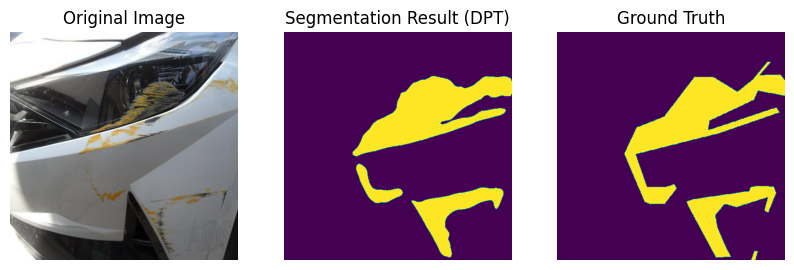

(512, 512)


In [ ]:
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def predict_segmentation(model, image_path, target_size=(512, 512)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB").resize((512, 512))
    inputs = processor_DPT(image, return_tensors="pt").to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # [batch_size, num_classes, height, width]

        # 출력 업샘플링 (512x512)
        resized_logits = F.interpolate(
            logits, size=target_size, mode="bilinear", align_corners=False
        )

        # 가장 높은 확률을 가진 클래스 선택
        preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()

    return preds

# 파일 경로
test_image_path = "/content/content/car_damage_data_v/test/image/0510560_sc-222421.jpg"  # 테스트할 이미지 경로
ground_truth_path = "/content/content/car_damage_data_v/masks/test/0510560_sc-222421_mask.png"  # 테스트할 이미지의 ground truth 경로

# 예측 수행
prediction = predict_segmentation(DPT, test_image_path, target_size=(512, 512))
ground_truth = Image.open(ground_truth_path).resize((512, 512))  # Ground Truth 크기 맞춤
image = Image.open(test_image_path).convert("RGB").resize((512, 512))  # 원본 이미지 크기 맞춤

# 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# 예측 결과
plt.subplot(1, 3, 2)
plt.title("Segmentation Result (DPT)")
plt.imshow(prediction, cmap='viridis')  # 예측 클래스 맵 시각화
plt.axis("off")

# Ground Truth
plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap='viridis')  # Ground Truth 시각화
plt.axis("off")

plt.show()
print(prediction.shape)

# Swin transformer

In [ ]:
import torch
from transformers import UperNetForSemanticSegmentation, AutoImageProcessor

# 모델과 프로세서 설정
model_name = "openmmlab/upernet-swin-tiny"  # 사전 학습된 모델 구조 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 프로세서 로드 (이미지 전처리용)
processor_Swin = AutoImageProcessor.from_pretrained(model_name)

# 모델 구조 로드 (가중치는 나중에 적용)
Swin = UperNetForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=2,  # 클래스 수 설정
    ignore_mismatched_sizes=True
).to(device)

# 네가 가진 .pth 파일 경로
custom_weights_path = "/content/drive/MyDrive/Assignments/심신개/심신개 데이터셋/SwinTransformer.pth"

# 가중치 불러오기
state_dict = torch.load(custom_weights_path, map_location=device)

# 모델에 가중치 적용
Swin.load_state_dict(state_dict, strict=False)  # strict=False로 일부 불일치 허용

print("커스텀 .pth 가중치가 Swin 모델에 성공적으로 적용되었습니다!")

Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-swin-tiny and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([2, 512, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-101-3dbf73a59662>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the d

커스텀 .pth 가중치가 Swin 모델에 성공적으로 적용되었습니다!


In [ ]:
def evaluate_swin_on_test_dataset(model, processor, test_dataset, id2label, num_classes=2):
    """
    Swin 모델을 사용해 테스트 세트 평가를 수행하는 함수.
    Args:
        model: Swin 모델
        processor: Swin 모델 전처리 프로세서
        test_dataset: 평가할 테스트셋 (image path와 mask path 포함)
        id2label: 클래스 ID와 라벨 이름 매핑 딕셔너리
        num_classes: 클래스 수 (default=2)
    Returns:
        metrics: IoU 및 Accuracy 결과
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    all_predictions = []
    all_references = []

    for example in tqdm(test_dataset, desc="Evaluating Swin on test dataset"):
        # 이미지와 라벨 경로 가져오기
        image_path = example["image"]
        mask_path = example["mask"]

        # Ground Truth 로드 및 전처리
        label = Image.open(mask_path).resize((512, 512))
        label = np.array(label, dtype=np.int64)
        label = torch.tensor(label).to(device)

        # 모델 예측
        with torch.no_grad():
            image = Image.open(image_path).convert("RGB").resize((512, 512))
            inputs = processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs)
            logits = outputs.logits

            # 크기 조정 및 argmax
            resized_logits = interpolate(logits, size=label.shape, mode="bilinear", align_corners=False)
            preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()

        # 결과 저장
        all_predictions.append(preds)
        all_references.append(label.cpu().numpy())

    # IoU 및 Accuracy 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=num_classes,
        ignore_index=None,
        reduce_labels=False,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    print("\nSwin Test Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics

id2label = {0: "background", 1: "damage"}
# 평가 실행 (Swin)
swin_metrics = evaluate_swin_on_test_dataset(Swin, processor_Swin, test_data, id2label, num_classes=2)
print(swin_metrics)


Evaluating Swin on test dataset: 100%|██████████| 1514/1514 [03:07<00:00,  8.06it/s]



Swin Test Dataset Evaluation Results:
mean_iou: 0.6516
mean_accuracy: 0.6961
overall_accuracy: 0.9406
accuracy_background: 0.9906
accuracy_damage: 0.4017
iou_background: 0.9385
iou_damage: 0.3647
{'mean_iou': 0.6516030800418174, 'mean_accuracy': 0.6961353387032444, 'overall_accuracy': 0.9405949717311279, 'accuracy_background': 0.9905960278663941, 'accuracy_damage': 0.40167464954009474, 'iou_background': 0.9384975353272749, 'iou_damage': 0.36470862475636007}


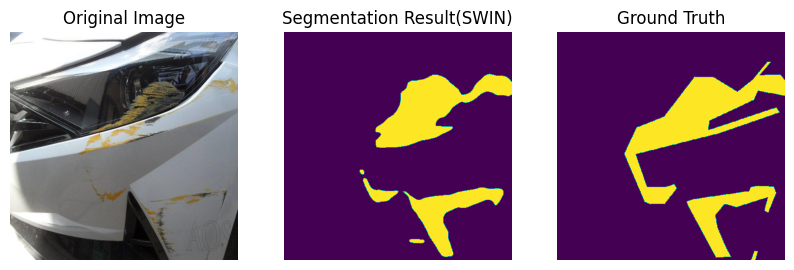

(512, 512)


In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

def predict_segmentation(model, image_path):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB").resize((512, 512))
    inputs = processor_Swin(image, return_tensors="pt").to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
    return preds

test_image_path = "/content/content/car_damage_data_v/test/image/0510560_sc-222421.jpg"  # 테스트할 이미지 경로
ground_truth_path = "/content/content/car_damage_data_v/masks/test/0510560_sc-222421_mask.png"  # 테스트할 이미지의 ground truth 경로

prediction = predict_segmentation(Swin, test_image_path)
ground_truth = Image.open(ground_truth_path).resize((512, 512))  # ground truth 이미지 크기 조정
image = Image.open(test_image_path).convert("RGB").resize((512, 512))  # 원본 이미지와 동일 크기

plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# 예측 결과
plt.subplot(1, 3, 2)
plt.title("Segmentation Result(SWIN)")
plt.imshow(prediction, cmap='viridis')  # 예측 클래스 맵 시각화
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap='viridis')  # 예측 클래스 맵 시각화
plt.axis("off")

plt.show()
print(prediction.shape)

In [ ]:
from safetensors.torch import load_file
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch
from PIL import Image

# Model & Processor
model_name = "/content/Segformer-model/config (4).json"
processor_Segformer = SegformerImageProcessor.from_pretrained("nvidia/mit-b3")
model_weights = load_file("/content/Segformer-model/model (1).safetensors")
Segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
    config=model_name)
Segformer.load_state_dict(model_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inference
Segformer.eval()
Segformer.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of the model checkpoint at nvidia/mit-b3 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkp

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
def evaluate_segformer_on_test_dataset(model, processor, test_dataset, id2label, num_classes=2):
    """
    Segformer 모델을 사용해 테스트 세트 평가를 수행하는 함수.
    Args:
        model: Segformer 모델
        processor: Segformer 모델 전처리 프로세서
        test_dataset: 평가할 테스트셋 (image path와 mask path 포함)
        id2label: 클래스 ID와 라벨 이름 매핑 딕셔너리
        num_classes: 클래스 수 (default=2)
    Returns:
        metrics: IoU 및 Accuracy 결과
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    all_predictions = []
    all_references = []

    for example in tqdm(test_dataset, desc="Evaluating Segformer on test dataset"):
        # 이미지와 라벨 경로 가져오기
        image_path = example["image"]
        mask_path = example["mask"]

        # Ground Truth 로드 및 전처리
        label = Image.open(mask_path).resize((512, 512))
        label = np.array(label, dtype=np.int64)
        label = torch.tensor(label).to(device)

        # 모델 예측
        with torch.no_grad():
            image = Image.open(image_path).convert("RGB").resize((512, 512))
            inputs = processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs)
            logits = outputs.logits

            # 크기 조정 및 argmax
            resized_logits = interpolate(logits, size=label.shape, mode="bilinear", align_corners=False)
            preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()

        # 결과 저장
        all_predictions.append(preds)
        all_references.append(label.cpu().numpy())

    # IoU 및 Accuracy 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=num_classes,
        ignore_index=None,
        reduce_labels=False,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    print("\nSegformer Test Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics

id2label = {0: "background", 1: "damage"}
# 평가 실행 (Segformer)
segformer_metrics = evaluate_segformer_on_test_dataset(Segformer, processor_Segformer, test_data, id2label, num_classes=2)
print(segformer_metrics)


Evaluating Segformer on test dataset: 100%|██████████| 1514/1514 [02:21<00:00, 10.73it/s]



Segformer Test Dataset Evaluation Results:
mean_iou: 0.7116
mean_accuracy: 0.7774
overall_accuracy: 0.9471
accuracy_background: 0.9817
accuracy_damage: 0.5731
iou_background: 0.9443
iou_damage: 0.4789
{'mean_iou': 0.7116200585545466, 'mean_accuracy': 0.7774321205781005, 'overall_accuracy': 0.9470520523454271, 'accuracy_background': 0.981745615552203, 'accuracy_damage': 0.573118625603998, 'iou_background': 0.944343860281173, 'iou_damage': 0.4788962568279201}


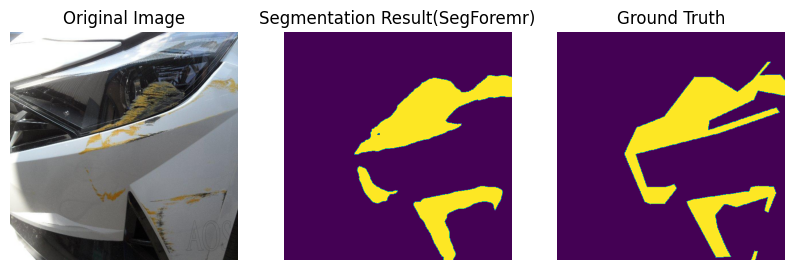

(512, 512)


In [ ]:
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def predict_segmentation(model, image_path, target_size=(512, 512)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB").resize((512, 512))
    inputs = processor_Segformer(image, return_tensors="pt").to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # [batch_size, num_classes, height, width]

        # 출력 업샘플링 (512x512)
        resized_logits = F.interpolate(
            logits, size=target_size, mode="bilinear", align_corners=False
        )

        # 가장 높은 확률을 가진 클래스 선택
        preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()

    return preds


test_image_path = "/content/content/car_damage_data_v/test/image/0510560_sc-222421.jpg"  # 테스트할 이미지 경로
ground_truth_path = "/content/content/car_damage_data_v/masks/test/0510560_sc-222421_mask.png"  # 테스트할 이미지의 ground truth 경로

prediction = predict_segmentation(Segformer, test_image_path)
ground_truth = Image.open(ground_truth_path).resize((512, 512))  # ground truth 이미지 크기 조정
image = Image.open(test_image_path).convert("RGB").resize((512, 512))  # 원본 이미지와 동일 크기

plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# 예측 결과
plt.subplot(1, 3, 2)
plt.title("Segmentation Result(SegFormer)")
plt.imshow(prediction, cmap='viridis')  # 예측 클래스 맵 시각화
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap='viridis')  # 예측 클래스 맵 시각화
plt.axis("off")

plt.show()
print(prediction.shape)

# 가중치 기반 hard voting (0.6 : 0.3 : 0.1)

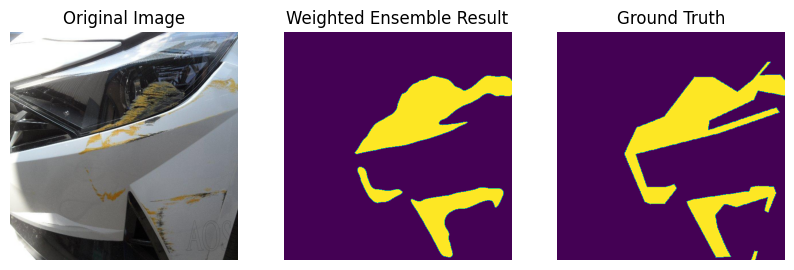

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# 가중치 적용된 앙상블 예측 함수
def ensemble_predictions(models, processors, image_path, target_size=(512, 512), weights=[0.6, 0.3, 0.1]):
    """
    여러 모델의 출력을 가중치 기반으로 앙상블해 최종 예측을 반환.
    Args:
        models: 리스트 형태의 모델들
        processors: 모델에 맞는 프로세서 리스트
        image_path: 입력 이미지 경로
        target_size: 출력 크기
        weights: 모델별 가중치 리스트
    Returns:
        final_preds: 앙상블된 최종 클래스 예측 맵
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ensemble_logits = []

    # 각 모델의 출력 계산
    for model, processor, weight in zip(models, processors, weights):
        model.to(device)
        model.eval()

        # 이미지 전처리
        image = Image.open(image_path).convert("RGB").resize(target_size)
        inputs = processor(images=image, return_tensors="pt").to(device)

        # 모델 예측
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits  # [1, num_classes, height, width]

            # 출력 크기 맞추기
            resized_logits = F.interpolate(logits, size=target_size, mode="bilinear", align_corners=False)

            # 가중치 적용
            ensemble_logits.append(weight * resized_logits.cpu().numpy())

    # 가중치 기반 평균 logits 계산 (Soft Voting)
    avg_logits = np.sum(ensemble_logits, axis=0)  # [1, num_classes, height, width]
    final_preds = np.argmax(avg_logits, axis=1).squeeze(0)  # 가장 높은 클래스 선택

    return final_preds

# 모델 및 프로세서 리스트
models = [DPT, Swin, Segformer]
processors = [processor_DPT, processor_Swin, processor_Segformer]

# 테스트 이미지 경로
test_image_path = "/content/content/car_damage_data_v/test/image/0510560_sc-222421.jpg"
ground_truth_path = "/content/content/car_damage_data_v/masks/test/0510560_sc-222421_mask.png"

# 가중치 기반 앙상블 예측 수행
ensemble_prediction = ensemble_predictions(models, processors, test_image_path, target_size=(512, 512))

# 시각화
ground_truth = Image.open(ground_truth_path).resize((512, 512))
image = Image.open(test_image_path).convert("RGB").resize((512, 512))

plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# 앙상블 결과
plt.subplot(1, 3, 2)
plt.title("Weighted Ensemble Result")
plt.imshow(ensemble_prediction, cmap="viridis")
plt.axis("off")

# Ground Truth
plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap="viridis")
plt.axis("off")

plt.show()


In [ ]:
from torch.nn.functional import interpolate
from tqdm import tqdm
import numpy as np
import torch
import evaluate
from PIL import Image

# mean IoU 메트릭 로드
metric = evaluate.load("mean_iou")

def evaluate_weighted_hard_voting_on_test_dataset(models, processors, test_dataset, id2label, num_classes=2, weights=None, debug_index=0):
    """
    Weighted Hard Voting 방식으로 앙상블 평가를 수행하는 함수.
    Args:
        models: 모델 리스트 (DPT, Swin, Segformer 등)
        processors: 모델에 맞는 이미지 프로세서 리스트
        test_dataset: 평가할 테스트셋 (image path와 mask path 포함)
        id2label: 클래스 ID와 라벨 이름 매핑 딕셔너리
        num_classes: 클래스 수 (default=2)
        weights: 모델별 가중치 리스트 (default=None, 모두 동일 가중치로 설정)
        debug_index: 검증할 샘플의 인덱스 (default=0)
    Returns:
        metrics: IoU 및 Accuracy 결과
    """
    if weights is None:
        weights = [1.0 / len(models)] * len(models)  # 동일한 가중치로 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in models:
        model.eval().to(device)

    all_predictions = []
    all_references = []

    for idx, example in enumerate(tqdm(test_dataset, desc="Evaluating test dataset")):
        # 원본 이미지와 Ground Truth 경로 가져오기
        image_path = example["image"]
        mask_path = example["mask"]

        # 라벨 로드
        label = Image.open(mask_path).resize((512, 512))
        label = np.array(label, dtype=np.int64)  # Ground Truth 마스크
        label = torch.tensor(label).to(device)

        # 모델별 예측 수행
        with torch.no_grad():
            weighted_vote_map = np.zeros((num_classes, *label.shape), dtype=np.float32)  # [num_classes, H, W]
            for model, processor, weight in zip(models, processors, weights):
                # 모델별 Processor로 이미지 전처리
                image = Image.open(image_path).convert("RGB").resize((512, 512))
                inputs = processor(images=image, return_tensors="pt").to(device)
                outputs = model(**inputs)
                logits = outputs.logits
                resized_logits = interpolate(logits, size=label.shape, mode="bilinear", align_corners=False)

                # 모델별 argmax로 클래스 예측
                preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()  # [H, W]

                # 픽셀별 가중치 적용
                for cls in range(num_classes):
                    weighted_vote_map[cls] += weight * (preds == cls)

            # 최종 클래스 결정 (가중 카운트에서 argmax)
            hard_voted_preds = np.argmax(weighted_vote_map, axis=0)  # [H, W]

        # 디버깅: 특정 인덱스 샘플 확인
        if idx == debug_index:
            print(f"--- Debug Info for Index {debug_index} ---")
            print(f"Label Shape: {label.shape}")
            print(f"Label Unique Values: {np.unique(label.cpu().numpy())}")
            print(f"Weighted Vote Map Shape: {weighted_vote_map.shape}")
            for cls in range(num_classes):
                print(f"Class {cls} Weighted Vote Map Stats: min={weighted_vote_map[cls].min()}, max={weighted_vote_map[cls].max()}")
            print(f"Hard Voting Result Unique Values: {np.unique(hard_voted_preds)}")
            print(f"Hard Voting Result Shape: {hard_voted_preds.shape}")

        # 결과 저장
        all_predictions.append(hard_voted_preds)
        all_references.append(label.cpu().numpy())

    # IoU 및 Accuracy 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=num_classes,
        ignore_index=None,
        reduce_labels=False,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    print("\nEnsemble Test Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics


# 데이터 경로
test_images_dir = "/content/content/car_damage_data_v/test/image"
test_masks_dir = "/content/content/car_damage_data_v/masks/test"

# 데이터 로드 (이미지 경로와 마스크 경로로 구성된 리스트 생성)
test_data = load_data(test_images_dir, test_masks_dir)

# 모델 및 프로세서 리스트
models = [DPT, Swin, Segformer]
processors = [processor_DPT, processor_Swin, processor_Segformer]

# 클래스 ID와 라벨 매핑
id2label = {0: "background", 1: "damage"}

# 모델별 가중치 설정
weights = [0.6, 0.3, 0.1]  # DPT: 60%, Swin: 30%, Segformer: 10%

# 평가 실행
metrics = evaluate_weighted_hard_voting_on_test_dataset(models, processors, test_data, id2label, num_classes=2, weights=weights, debug_index=0)
print(metrics)


Evaluating test dataset:   0%|          | 1/1514 [00:00<11:09,  2.26it/s]

--- Debug Info for Index 0 ---
Label Shape: torch.Size([512, 512])
Label Unique Values: [0 1]
Weighted Vote Map Shape: (2, 512, 512)
Class 0 Weighted Vote Map Stats: min=0.0, max=1.0
Class 1 Weighted Vote Map Stats: min=0.0, max=1.0
Hard Voting Result Unique Values: [0 1]
Hard Voting Result Shape: (512, 512)


Evaluating test dataset: 100%|██████████| 1514/1514 [08:10<00:00,  3.08it/s]



Ensemble Test Dataset Evaluation Results:
mean_iou: 0.7054
mean_accuracy: 0.7655
overall_accuracy: 0.9469
accuracy_background: 0.9840
accuracy_damage: 0.5470
iou_background: 0.9443
iou_damage: 0.4664
{'mean_iou': 0.7053645503406233, 'mean_accuracy': 0.7655078831912192, 'overall_accuracy': 0.9468716831786786, 'accuracy_background': 0.9839673027366275, 'accuracy_damage': 0.5470484636458111, 'iou_background': 0.9442838969741062, 'iou_damage': 0.4664452037071403}


# 단순 hard voting(1:1:1)

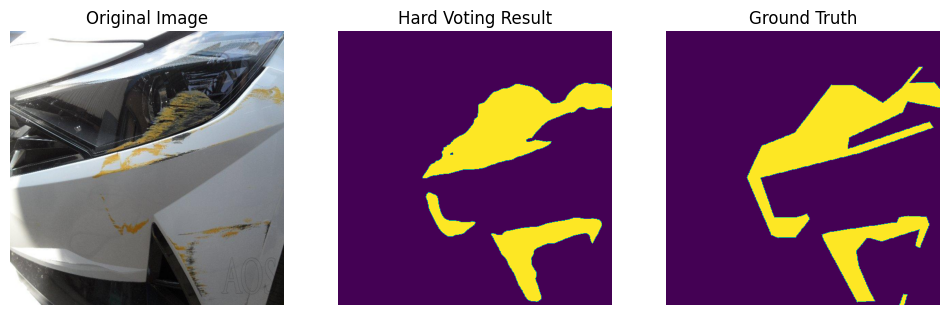

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.functional import interpolate
from PIL import Image

# Hard Voting 앙상블 예측 함수
def hard_voting_predictions(models, processors, image_path, target_size=(512, 512), num_classes=2):
    """
    Hard Voting 앙상블 방식으로 예측을 수행하고 최종 결과 반환.
    Args:
        models: 모델 리스트
        processors: 모델에 맞는 프로세서 리스트
        image_path: 입력 이미지 경로
        target_size: 출력 크기
        num_classes: 클래스 수
    Returns:
        hard_voted_preds: Hard Voting 결과 클래스 맵
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    individual_predictions = []

    for model, processor in zip(models, processors):
        model.eval().to(device)

        # 이미지 전처리
        image = Image.open(image_path).convert("RGB").resize(target_size)
        inputs = processor(images=image, return_tensors="pt").to(device)

        # 모델 예측
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits  # [1, num_classes, height, width]

            # 출력 크기 맞추기
            resized_logits = interpolate(logits, size=target_size, mode="bilinear", align_corners=False)

            # argmax로 클래스 예측
            preds = torch.argmax(resized_logits, dim=1).squeeze(0)  # [height, width]
            individual_predictions.append(preds.cpu().numpy())

    # Hard Voting: 다수결로 픽셀별 클래스 선택
    individual_predictions = np.array(individual_predictions)  # [num_models, height, width]
    hard_voted_preds = np.apply_along_axis(
        lambda x: np.bincount(x, minlength=num_classes).argmax(), axis=0, arr=individual_predictions
    )  # [height, width]

    return hard_voted_preds

# 모델 및 프로세서 리스트
models = [DPT, Swin, Segformer]
processors = [processor_DPT, processor_Swin, processor_Segformer]

# 테스트 이미지 경로
test_image_path = "/content/content/car_damage_data_v/test/image/0510560_sc-222421.jpg"
ground_truth_path = "/content/content/car_damage_data_v/masks/test/0510560_sc-222421_mask.png"

# Hard Voting 수행
hard_voting_result = hard_voting_predictions(models, processors, test_image_path, target_size=(512, 512))

# 시각화
ground_truth = Image.open(ground_truth_path).resize((512, 512))
image = Image.open(test_image_path).convert("RGB").resize((512, 512))

plt.figure(figsize=(12, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# Hard Voting 결과
plt.subplot(1, 3, 2)
plt.title("Hard Voting Result")
plt.imshow(hard_voting_result, cmap="viridis")
plt.axis("off")

# Ground Truth
plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap="viridis")
plt.axis("off")

plt.show()


In [ ]:
from torch.nn.functional import interpolate
from tqdm import tqdm
import numpy as np
import torch
import evaluate
from PIL import Image

# mean IoU 메트릭 로드
metric = evaluate.load("mean_iou")

def evaluate_hard_voting_on_test_dataset(models, processors, test_dataset, id2label, num_classes=2, debug_index=0):
    """
    Hard Voting 방식으로 앙상블 평가를 수행하는 함수.
    Args:
        models: 모델 리스트 (DPT, Swin, Segformer 등)
        processors: 모델에 맞는 이미지 프로세서 리스트
        test_dataset: 평가할 테스트셋 (image path와 mask path 포함)
        id2label: 클래스 ID와 라벨 이름 매핑 딕셔너리
        num_classes: 클래스 수 (default=2)
        debug_index: 검증할 샘플의 인덱스 (default=0)
    Returns:
        metrics: IoU 및 Accuracy 결과
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in models:
        model.eval().to(device)

    all_predictions = []
    all_references = []

    for idx, example in enumerate(tqdm(test_dataset, desc="Evaluating test dataset")):
        # 원본 이미지와 Ground Truth 경로 가져오기
        image_path = example["image"]
        mask_path = example["mask"]

        # 라벨 로드
        label = Image.open(mask_path).resize((512, 512))
        label = np.array(label, dtype=np.int64)  # Ground Truth 마스크
        label = torch.tensor(label).to(device)

        # 모델별 예측 수행
        with torch.no_grad():
            individual_predictions = []
            for model, processor in zip(models, processors):
                # 모델별 Processor로 이미지 전처리
                image = Image.open(image_path).convert("RGB").resize((512, 512))
                inputs = processor(images=image, return_tensors="pt").to(device)
                outputs = model(**inputs)
                logits = outputs.logits
                resized_logits = interpolate(logits, size=label.shape, mode="bilinear", align_corners=False)

                # 모델별 argmax로 클래스 예측
                preds = torch.argmax(resized_logits, dim=1).squeeze(0)  # [H, W]
                individual_predictions.append(preds.cpu().numpy())

            # Hard Voting (픽셀별 다수결)
            individual_predictions = np.array(individual_predictions)  # [num_models, H, W]
            hard_voted_preds = np.apply_along_axis(
                lambda x: np.bincount(x, minlength=num_classes).argmax(), axis=0, arr=individual_predictions
            )  # [H, W]

        # 디버깅: 특정 인덱스 샘플 확인
        if idx == debug_index:
            print(f"--- Debug Info for Index {debug_index} ---")
            print(f"Label Shape: {label.shape}")
            print(f"Label Unique Values: {np.unique(label.cpu().numpy())}")
            for i, pred in enumerate(individual_predictions):
                print(f"Model {i+1} Prediction Unique Values: {np.unique(pred)}")
            print(f"Hard Voting Result Unique Values: {np.unique(hard_voted_preds)}")
            print(f"Hard Voting Result Shape: {hard_voted_preds.shape}")

        # 결과 저장
        all_predictions.append(hard_voted_preds)
        all_references.append(label.cpu().numpy())

    # IoU 및 Accuracy 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=num_classes,
        ignore_index=None,
        reduce_labels=False,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    print("\nEnsemble Test Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics


# 데이터 경로
test_images_dir = "/content/content/car_damage_data_v/test/image"
test_masks_dir = "/content/content/car_damage_data_v/masks/test"

# 데이터 로드 (이미지 경로와 마스크 경로로 구성된 리스트 생성)
test_data = load_data(test_images_dir, test_masks_dir)

# 모델 및 프로세서 리스트
models = [DPT, Swin, Segformer]
processors = [processor_DPT, processor_Swin, processor_Segformer]

# 클래스 ID와 라벨 매핑
id2label = {0: "background", 1: "damage"}

# 평가 실행
metrics = evaluate_hard_voting_on_test_dataset(models, processors, test_data, id2label, num_classes=2, debug_index=0)
print(metrics)


Evaluating test dataset:   0%|          | 1/1514 [00:01<28:10,  1.12s/it]

--- Debug Info for Index 0 ---
Label Shape: torch.Size([512, 512])
Label Unique Values: [0 1]
Model 1 Prediction Unique Values: [0 1]
Model 2 Prediction Unique Values: [0 1]
Model 3 Prediction Unique Values: [0 1]
Hard Voting Result Unique Values: [0 1]
Hard Voting Result Shape: (512, 512)


Evaluating test dataset: 100%|██████████| 1514/1514 [24:10<00:00,  1.04it/s]
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")



Ensemble Test Dataset Evaluation Results:
mean_iou: 0.7011
mean_accuracy: 0.7524
overall_accuracy: 0.9478
accuracy_background: 0.9878
accuracy_damage: 0.5171
iou_background: 0.9454
iou_damage: 0.4568
{'mean_iou': 0.7011234984016351, 'mean_accuracy': 0.7524431711893937, 'overall_accuracy': 0.9477993021553069, 'accuracy_background': 0.9877568720403966, 'accuracy_damage': 0.5171294703383907, 'iou_background': 0.9454021437301418, 'iou_damage': 0.45684485307312855}


# 가중치 hard voting (0.6:0.4) dpt, segformer

In [ ]:
from torch.nn.functional import interpolate
from tqdm import tqdm
import numpy as np
import torch
import evaluate
from PIL import Image

# mean IoU 메트릭 로드
metric = evaluate.load("mean_iou")

def evaluate_weighted_hard_voting_on_test_dataset(models, processors, test_dataset, id2label, num_classes=2, weights=None, debug_index=0):
    """
    Weighted Hard Voting 방식으로 앙상블 평가를 수행하는 함수.
    Args:
        models: 모델 리스트 (DPT, Swin, Segformer 등)
        processors: 모델에 맞는 이미지 프로세서 리스트
        test_dataset: 평가할 테스트셋 (image path와 mask path 포함)
        id2label: 클래스 ID와 라벨 이름 매핑 딕셔너리
        num_classes: 클래스 수 (default=2)
        weights: 모델별 가중치 리스트 (default=None, 모두 동일 가중치로 설정)
        debug_index: 검증할 샘플의 인덱스 (default=0)
    Returns:
        metrics: IoU 및 Accuracy 결과
    """
    if weights is None:
        weights = [1.0 / len(models)] * len(models)  # 동일한 가중치로 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in models:
        model.eval().to(device)

    all_predictions = []
    all_references = []

    for idx, example in enumerate(tqdm(test_dataset, desc="Evaluating test dataset")):
        # 원본 이미지와 Ground Truth 경로 가져오기
        image_path = example["image"]
        mask_path = example["mask"]

        # 라벨 로드
        label = Image.open(mask_path).resize((512, 512))
        label = np.array(label, dtype=np.int64)  # Ground Truth 마스크
        label = torch.tensor(label).to(device)

        # 모델별 예측 수행
        with torch.no_grad():
            weighted_vote_map = np.zeros((num_classes, *label.shape), dtype=np.float32)  # [num_classes, H, W]
            for model, processor, weight in zip(models, processors, weights):
                # 모델별 Processor로 이미지 전처리
                image = Image.open(image_path).convert("RGB").resize((512, 512))
                inputs = processor(images=image, return_tensors="pt").to(device)
                outputs = model(**inputs)
                logits = outputs.logits
                resized_logits = interpolate(logits, size=label.shape, mode="bilinear", align_corners=False)

                # 모델별 argmax로 클래스 예측
                preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()  # [H, W]

                # 픽셀별 가중치 적용
                for cls in range(num_classes):
                    weighted_vote_map[cls] += weight * (preds == cls)

            # 최종 클래스 결정 (가중 카운트에서 argmax)
            hard_voted_preds = np.argmax(weighted_vote_map, axis=0)  # [H, W]

        # 디버깅: 특정 인덱스 샘플 확인
        if idx == debug_index:
            print(f"--- Debug Info for Index {debug_index} ---")
            print(f"Label Shape: {label.shape}")
            print(f"Label Unique Values: {np.unique(label.cpu().numpy())}")
            print(f"Weighted Vote Map Shape: {weighted_vote_map.shape}")
            for cls in range(num_classes):
                print(f"Class {cls} Weighted Vote Map Stats: min={weighted_vote_map[cls].min()}, max={weighted_vote_map[cls].max()}")
            print(f"Hard Voting Result Unique Values: {np.unique(hard_voted_preds)}")
            print(f"Hard Voting Result Shape: {hard_voted_preds.shape}")

        # 결과 저장
        all_predictions.append(hard_voted_preds)
        all_references.append(label.cpu().numpy())

    # IoU 및 Accuracy 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=num_classes,
        ignore_index=None,
        reduce_labels=False,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    print("\nEnsemble Test Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics


# 데이터 경로
test_images_dir = "/content/content/car_damage_data_v/test/image"
test_masks_dir = "/content/content/car_damage_data_v/masks/test"

# 데이터 로드 (이미지 경로와 마스크 경로로 구성된 리스트 생성)
test_data = load_data(test_images_dir, test_masks_dir)

# 모델 및 프로세서 리스트
models = [DPT, Segformer]
processors = [processor_DPT, processor_Segformer]

# 클래스 ID와 라벨 매핑
id2label = {0: "background", 1: "damage"}

# 모델별 가중치 설정
weights = [0.4, 0.6]

# 평가 실행
metrics = evaluate_weighted_hard_voting_on_test_dataset(models, processors, test_data, id2label, num_classes=2, weights=weights, debug_index=0)
print(metrics)


Evaluating test dataset:   0%|          | 1/1514 [00:00<07:24,  3.40it/s]

--- Debug Info for Index 0 ---
Label Shape: torch.Size([512, 512])
Label Unique Values: [0 1]
Weighted Vote Map Shape: (2, 512, 512)
Class 0 Weighted Vote Map Stats: min=0.0, max=1.0
Class 1 Weighted Vote Map Stats: min=0.0, max=1.0
Hard Voting Result Unique Values: [0 1]
Hard Voting Result Shape: (512, 512)


Evaluating test dataset: 100%|██████████| 1514/1514 [05:10<00:00,  4.87it/s]



Ensemble Test Dataset Evaluation Results:
mean_iou: 0.6910
mean_accuracy: 0.7374
overall_accuracy: 0.9470
accuracy_background: 0.9899
accuracy_damage: 0.4850
iou_background: 0.9447
iou_damage: 0.4372
{'mean_iou': 0.6909645301629794, 'mean_accuracy': 0.7374182915611907, 'overall_accuracy': 0.9469971801677185, 'accuracy_background': 0.9898638311733936, 'accuracy_damage': 0.4849727519489878, 'iou_background': 0.9447210396871191, 'iou_damage': 0.43720802063883984}


# OR voting! (DPT, Segformer) 둘중 하나라도 1 출력시 1로 간주

In [ ]:
def evaluate_or_hard_voting_on_test_dataset(models, processors, test_dataset, id2label, num_classes=2, weights=None, debug_index=0):
    """
    OR 방식으로 앙상블 평가를 수행하는 함수 (하나의 모델이라도 1로 예측하면 최종 예측은 1).
    Args:
        models: 모델 리스트 (DPT, Segformer 등)
        processors: 모델에 맞는 이미지 프로세서 리스트
        test_dataset: 평가할 테스트셋 (image path와 mask path 포함)
        id2label: 클래스 ID와 라벨 이름 매핑 딕셔너리
        num_classes: 클래스 수 (default=2)
        weights: 모델별 가중치 리스트 (default=None, 사용 안 함)
        debug_index: 검증할 샘플의 인덱스 (default=0)
    Returns:
        metrics: IoU 및 Accuracy 결과
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in models:
        model.eval().to(device)

    all_predictions = []
    all_references = []

    for idx, example in enumerate(tqdm(test_dataset, desc="Evaluating OR Hard Voting on test dataset")):
        # 원본 이미지와 Ground Truth 경로 가져오기
        image_path = example["image"]
        mask_path = example["mask"]

        # 라벨 로드
        label = Image.open(mask_path).resize((512, 512))
        label = np.array(label, dtype=np.int64)  # Ground Truth 마스크
        label = torch.tensor(label).to(device)

        # 모델별 예측 수행
        with torch.no_grad():
            or_voted_preds = np.zeros(label.shape, dtype=np.int64)  # OR Voting 초기화
            for model, processor in zip(models, processors):
                # 모델별 Processor로 이미지 전처리
                image = Image.open(image_path).convert("RGB").resize((512, 512))
                inputs = processor(images=image, return_tensors="pt").to(device)
                outputs = model(**inputs)
                logits = outputs.logits
                resized_logits = interpolate(logits, size=label.shape, mode="bilinear", align_corners=False)

                # 모델별 argmax로 클래스 예측
                preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()  # [H, W]

                # OR Voting: 하나라도 1이면 최종 예측은 1
                or_voted_preds = np.logical_or(or_voted_preds, preds).astype(np.int64)

        # 디버깅: 특정 인덱스 샘플 확인
        if idx == debug_index:
            print(f"--- Debug Info for Index {debug_index} ---")
            print(f"Label Shape: {label.shape}")
            print(f"Label Unique Values: {np.unique(label.cpu().numpy())}")
            print(f"OR Voting Result Unique Values: {np.unique(or_voted_preds)}")
            print(f"OR Voting Result Shape: {or_voted_preds.shape}")

        # 결과 저장
        all_predictions.append(or_voted_preds)
        all_references.append(label.cpu().numpy())

    # IoU 및 Accuracy 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=num_classes,
        ignore_index=None,
        reduce_labels=False,
    )

    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    print("\nOR Voting Test Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics


# 평가 실행
metrics = evaluate_or_hard_voting_on_test_dataset(models, processors, test_data, id2label, num_classes=2, debug_index=0)
print(metrics)


Evaluating OR Hard Voting on test dataset:   0%|          | 1/1514 [00:00<07:56,  3.17it/s]

--- Debug Info for Index 0 ---
Label Shape: torch.Size([512, 512])
Label Unique Values: [0 1]
OR Voting Result Unique Values: [0 1]
OR Voting Result Shape: (512, 512)


Evaluating OR Hard Voting on test dataset: 100%|██████████| 1514/1514 [05:04<00:00,  4.97it/s]



OR Voting Test Dataset Evaluation Results:
mean_iou: 0.7240
mean_accuracy: 0.8055
overall_accuracy: 0.9469
accuracy_background: 0.9758
accuracy_damage: 0.6352
iou_background: 0.9439
iou_damage: 0.5040
{'mean_iou': 0.7239512526343963, 'mean_accuracy': 0.805521712208129, 'overall_accuracy': 0.9469265553563873, 'accuracy_background': 0.9758490871154368, 'accuracy_damage': 0.6351943373008211, 'iou_background': 0.9439011583746844, 'iou_damage': 0.5040013468941081}


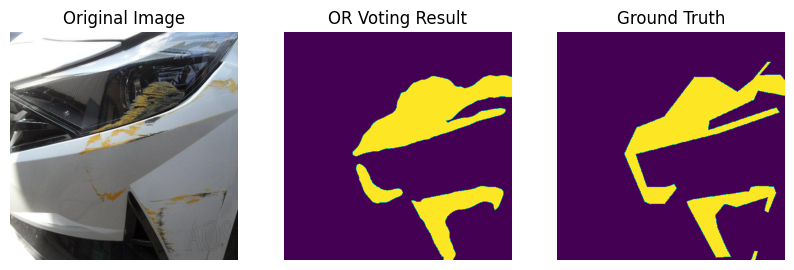

In [ ]:
from torch.nn.functional import interpolate
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

def inference_or_voting(models, processors, image_path, num_classes=2, target_size=(512, 512)):
    """
    OR Voting 기반 앙상블 Inference를 수행하는 함수.
    Args:
        models: 모델 리스트 (DPT, Swin, Segformer 등)
        processors: 모델에 맞는 프로세서 리스트
        image_path: 테스트 이미지 경로
        num_classes: 클래스 수 (default=2)
        target_size: 출력 이미지 크기 (default=(512, 512))
    Returns:
        final_prediction: OR Voting 결과로 생성된 클래스 맵
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for model in models:
        model.eval().to(device)

    # 원본 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB").resize(target_size)

    with torch.no_grad():
        or_voted_preds = np.zeros(target_size, dtype=np.int64)  # OR Voting 초기화
        for model, processor in zip(models, processors):
            inputs = processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs)
            logits = outputs.logits
            resized_logits = interpolate(logits, size=target_size, mode="bilinear", align_corners=False)

            # 모델별 argmax로 클래스 예측
            preds = torch.argmax(resized_logits, dim=1).squeeze(0).cpu().numpy()  # [H, W]

            # OR Voting: 하나라도 1이면 최종 예측은 1
            or_voted_preds = np.logical_or(or_voted_preds, preds).astype(np.int64)

    return or_voted_preds


# OR Voting 기반 Inference 수행
test_image_path = "/content/content/car_damage_data_v/test/image/0510560_sc-222421.jpg"
ground_truth_path = "/content/content/car_damage_data_v/masks/test/0510560_sc-222421_mask.png"

# 모델 및 프로세서 리스트
models = [DPT, Segformer]
processors = [processor_DPT, processor_Segformer]

# OR Voting 결과 생성
or_voting_prediction = inference_or_voting(models, processors, test_image_path, num_classes=2)

# 시각화
image = Image.open(test_image_path).convert("RGB").resize((512, 512))
ground_truth = Image.open(ground_truth_path).resize((512, 512))

plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# OR Voting 결과
plt.subplot(1, 3, 2)
plt.title("OR Voting Result")
plt.imshow(or_voting_prediction, cmap="viridis")
plt.axis("off")

# Ground Truth
plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(ground_truth, cmap="viridis")
plt.axis("off")

plt.show()
